[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# For Google Gemini (Google AI)
_set_env("GOOGLE_API_KEY")


We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were studying science?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about Herbivores. But what others should I learn about?", name="Nischala"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were studying science?
================================ Human Message =================================
Name: Nischala

Yes, I know about Herbivores. But what others should I learn about?


Recall we can pass them to a chat model.

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI
import os, getpass
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

# Invoke the model with messages
response = llm.invoke(messages)

print(response)

content='That\'s great! Knowing about herbivores is an excellent start. To get a more complete picture of how animals fit into ecosystems, you should definitely learn about the other major dietary classifications.\n\nHere are the key ones:\n\n1.  **Carnivores:**\n    *   **What they eat:** Meat. They primarily feed on other animals.\n    *   **Examples:** Lions, tigers, wolves, eagles, sharks, snakes.\n    *   **Key characteristics:** Often have sharp teeth (canines), claws, and keen senses (sight, smell, hearing) to hunt and capture prey. Some are ambush predators, others chase.\n\n2.  **Omnivores:**\n    *   **What they eat:** Both plants and animals. They have a diverse diet.\n    *   **Examples:** Humans, bears, raccoons, pigs, chickens, many primates.\n    *   **Key characteristics:** Very adaptable, as they can find food from various sources. Their teeth are often a mix, suitable for grinding plants and tearing meat.\n\n3.  **Detritivores / Decomposers:**\n    *   **What they eat

We can run our chat model in a simple graph with `MessagesState`.

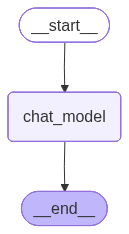

In [7]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were studying science?
================================ Human Message =================================
Name: Nischala

Yes, I know about Herbivores. But what others should I learn about?
================================== Ai Message ==================================

That's great you're starting with Herbivores! They're a fundamental part of any ecosystem.

To broaden your understanding of animal diets, here are the other key categories you should learn about, along with some more specific sub-categories:

1.  **Carnivores:**
    *   **Definition:** Animals that primarily eat other animals. Their digestive systems are adapted to break down meat.
    *   **Examples:** Lions, tigers, wolves, eagles, sharks, snakes.
    *   **Sub-categories (more specific diets within carnivores):**
        *   **Insectivores:** Primarily eat insects. (e.g., anteaters, aardvarks, many birds, bats,

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

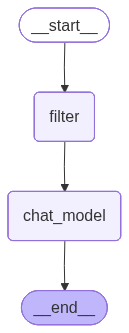

In [9]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="a")]
messages.append(HumanMessage("Hi.", name="Nischala", id="b"))
messages.append(AIMessage("So you said you were studying science?", name="Bot", id="c"))
messages.append(HumanMessage("Yes, I know about Herbivores. But what others should I learn about?", name="Nischala", id="d"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were studying science?
================================ Human Message =================================
Name: Nischala

Yes, I know about Herbivores. But what others should I learn about?
================================== Ai Message ==================================

That's a great start! Understanding herbivores (primary consumers) is fundamental. To build on that, you should definitely learn about the other major feeding categories and how they all interact within an ecosystem.

Here's a breakdown of what else to learn about:

1.  **Carnivores:**
    *   **What they are:** Animals that primarily eat other animals.
    *   **Examples:** Lions, wolves, eagles, sharks.
    *   **Key concept:** They are secondary, tertiary, or even quaternary consumers, depending on what their prey eats.

2.  **Omnivores:**
    *   **What they are:** Animals that eat both plants and animals.
    

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

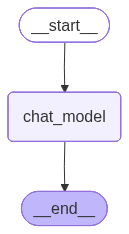

In [11]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [13]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Carnivores!", name="Nischala"))

In [14]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Nischala

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were studying science?
================================ Human Message =================================
Name: Nischala

Yes, I know about Herbivores. But what others should I learn about?
================================== Ai Message ==================================

That's a great start! Understanding herbivores (primary consumers) is fundamental. To build on that, you should definitely learn about the other major feeding categories and how they all interact within an ecosystem.

Here's a breakdown of what else to learn about:

1.  **Carnivores:**
    *   **What they are:** Animals that primarily eat other animals.
    *   **Examples:** Lions, wolves, eagles, sharks.
    *   **Key co

In [15]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Nischala

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were studying science?
================================ Human Message =================================
Name: Nischala

Yes, I know about Herbivores. But what others should I learn about?
================================== Ai Message ==================================

That's a great start! Understanding herbivores (primary consumers) is fundamental. To build on that, you should definitely learn about the other major feeding categories and how they all interact within an ecosystem.

Here's a breakdown of what else to learn about:

1.  **Carnivores:**
    *   **What they are:** Animals that primarily eat other animals.
    *   **Examples:** Lions, wolves, eagles, sharks.
    *   **Key co

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

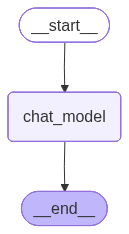

In [21]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import trim_messages
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")  

# Node function
def chat_model_node(state: MessagesState):
    messages = trim_messages(
        state["messages"],
        max_tokens=100,
        strategy="last",
        token_counter=llm,  
        allow_partial=False,
    )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

# Compile graph
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [22]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me what Omnivores eat!", name="Nischala"))

In [23]:
# Example of trimming messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import trim_messages

trimmed = trim_messages(
    messages,
    max_tokens=100,
    strategy="last",
    token_counter=ChatGoogleGenerativeAI(model="gemini-2.5-flash"),  
    allow_partial=False
)


In [24]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r